# Experimenting with EDA and Modeling 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pymongo
from pprint import pprint
import pickle
%load_ext autoreload
%autoreload 2
%matplotlib inline
sns.set_style('whitegrid')

import helper_functions
import plotly.express as px
import plotly.graph_objects as go
from plotly import subplots

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn import metrics


### First off, connect to MongoDB

In [2]:
client = pymongo.MongoClient('mongodb://localhost/')
db = client.admin

# Issue the serverStatus command and print the results
serverStatusResult=db.command("serverStatus")
pprint(serverStatusResult)

mydb = client['energy_data']


{'asserts': {'msg': 0, 'regular': 0, 'rollovers': 0, 'user': 52, 'warning': 0},
 'connections': {'active': 1,
                 'available': 3272,
                 'current': 4,
                 'totalCreated': 870},
 'electionMetrics': {'averageCatchUpOps': 0.0,
                     'catchUpTakeover': {'called': 0, 'successful': 0},
                     'electionTimeout': {'called': 0, 'successful': 0},
                     'freezeTimeout': {'called': 0, 'successful': 0},
                     'numCatchUps': 0,
                     'numCatchUpsAlreadyCaughtUp': 0,
                     'numCatchUpsFailedWithError': 0,
                     'numCatchUpsFailedWithNewTerm': 0,
                     'numCatchUpsFailedWithReplSetAbortPrimaryCatchUpCmd': 0,
                     'numCatchUpsSkipped': 0,
                     'numCatchUpsSucceeded': 0,
                     'numCatchUpsTimedOut': 0,
                     'numStepDownsCausedByHigherTerm': 0,
                     'priorityTakeover': {'

                        'slot joins yield time (usecs)': 0,
                        'slot transitions unable to find free slot': 0,
                        'slot unbuffered writes': 0,
                        'total in-memory size of compressed records': 1097247,
                        'total log buffer size': 33554432,
                        'total size of compressed records': 412028,
                        'written slots coalesced': 0,
                        'yields waiting for previous log file close': 0},
                'perf': {'file system read latency histogram (bucket 1) - 10-49ms': 9,
                         'file system read latency histogram (bucket 2) - 50-99ms': 2,
                         'file system read latency histogram (bucket 3) - 100-249ms': 1,
                         'file system read latency histogram (bucket 4) - 250-499ms': 2,
                         'file system read latency histogram (bucket 5) - 500-999ms': 0,
                         'file system re

In [3]:
print(client.list_database_names())

['admin', 'config', 'energy_data', 'local']


In [4]:
energy_collection = mydb['energy_data']

## Get all states' data

In [5]:
# Get dict with state abbreviations and full names
import csv
state_abbrevs = open('state-abbreviations.csv')
state_abbrevs_reader = csv.reader(state_abbrevs)
state_abbrevs_dict = dict(state_abbrevs_reader)

In [6]:
# Store each state's data from mongodb into a list 
states_data = []
for state in state_abbrevs_dict:
    data = [x for x in energy_collection.find({'state':state_abbrevs_dict[state]})]
    states_data.append({'state':state_abbrevs_dict[state], 'data':data})
    
# Make a separate one for total US data
country_data = [x for x in energy_collection.find({'state':'United States'})]

In [7]:
sectors = [series.get('sector') for series in states_data[0]['data'] if series.get('sector')]
sectors = list(set(sectors))
    

In [8]:
# Make a dict containing dataframes for each state organized by sector

state_dfs = {}
for state in states_data:
    dfs = {sector: helper_functions.get_energy_pop_df(state['data'],sector) for sector in sectors}
    state_dfs[state['state']] = dfs
    
# Make one of the whole country as well
country_dfs = {sector: helper_functions.get_energy_pop_df(country_data,sector) for sector in sectors}

In [9]:
state_dfs.keys()

dict_keys(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'])

In [10]:
# Save these dataframes as pickle files so that we don't have to go through this whole process multiple times.
# Also will be very useful for the Dash app to speed up load times.
with open('state_dfs.pickle', 'wb') as f:
    pickle.dump(state_dfs, f)

with open('country_dfs.pickle', 'wb') as f:
    pickle.dump(state_dfs, f)

In [23]:
# Create a dataframe with just the temperature data
temp_df = helper_functions.get_weather_df(states_data[0]['data'])

In [35]:
def plot_clusters(cluster_list):
    """
    Plots Nonrenewable vs. Renewable Energy consumption for states 
    in the same sustainability cluster.
    
    
    Parameters
    ----------
    
    cluster_list: list of state names that belong to the cluster
    
    
    Returns
    -------
    A plotly go figure with relevant traces
    """

    fig = go.Figure()
    for state in cluster_list:

        plot_df = state_dfs[state]['Total All Sectors']

        fig.add_trace(go.Scatter(
            x=plot_df.index,        
            y=plot_df['Nonrenewable Sources'],           
            mode=None, 
            fill=None,
            name=f'{state} Nonrenewable',
            line_color='#6785be'
            )
        )

        fig.add_trace(go.Scatter(
            x=plot_df.index,               
            y=plot_df['Renewable Sources'],                
            mode=None,  
    #         fill = 'tonexty',
    #         hoveron = 'points+fills',
            name=f'{state} Renewable',        
            line_color='#f8432d'
            )
        )


    fig.update_layout(
        title = f'Renewable vs. Nonrenewable Energy Consumption - Total All Sectors',
        template = "plotly_white",
        xaxis_title = 'Year',
        yaxis_title = 'Energy Consumption (Billion Btu)',
        yaxis_showgrid=False,
        xaxis_showgrid=False,
        yaxis_ticks='outside',
        yaxis_tickcolor='white',
        yaxis_ticklen=10,
        yaxis_zeroline=True,
        xaxis_range=['2000-01-01', '2017-01-01'],
        width = 1000, #1000
        height = 600,  #600      
        )
    fig.show()

# Creating metrics to measure the sustainability of a state

I'm going to define three metrics that will measure how sustainable the 50 states have been since the year 2000, as technology has improved and increased access to renewable energy sources. I will thus define the following:

- **Effort Score**: a measure of *change* in a state's nonrenewable energy consumption (NEC)
- **Green Score**: a measure of how *close* a state's NEC is to their renewable energy consumption (REC).
- **Sustainability Index**: A weighted combination of effort score and green score.

## Effort Score

We are going to measure how a state's NEC and REC change over time. This can be accomplished by quantifying how much the area between the NEC and REC curves change over time. This trend is modeled using ols linear regression in scikit-learn. The effort score is the slope of the line of best fit such that a state that is more greatly switching from NEC to REC will have a greater negative slope and thus is making more efforts to switch to renewable energy and vice versa.  


#### Algorithm

- Use $$\int^b_a{\text{NEC }dt} - \int^b_a{\text{REC } dt} = \int^b_a{\text{NEC }-\text{REC }dt}$$ $$$$ to integrate the series for every two adjacent data points using `np.trapz(x, y)` for every time interval from 2000-2017.
- Generate new series of values from each integration
- Create a linear model of this series using ols in scikit-learn
- $\text{Effort Score }= - \text{ slope}$ such that a higher and more positive effort score reflects a state has done more to use less NEC and more REC.


## Green Score

This is a measure of how far REC is from NEC. The idea is that states with very similar REC and NEC will likely have a low effort score despite being quite "green" for using similar amounts of REC and NEC. The green score seeks to reward these states by measuring the average ratio of REC to NEC from 2000-2017.


#### Algorithm

- For each year, compute $\frac{\text{REC}}{\text{NEC}}$. A score closer to 1 is more "green"
- Take the average of all of these and assign to the green score



In [286]:
# Create empty container to store the final processed data (sustainability indicators)
sus_indicators = {}

# Iterate through each state
for state in state_dfs:
    
    # Store series of REC and NEC
    rec = state_dfs[state]['Total All Sectors']['Renewable Sources']
    nec = state_dfs[state]['Total All Sectors']['Nonrenewable Sources']

    # Divide by 10^5 to have a more interpretable scale
    rec = rec / 100000
    nec = nec / 100000

    """
    EFFORT SCORE: 
    -------------
    """
    
    # Calculate the differences from the year 2000 onward
    diff = (nec - rec)[:'2000-01-01'].sort_index(ascending=True)
    
    # Create empty bin to store integral values
    integrals = []
    
    # Iterate through list of differences
    for i in range(len(diff)):
        
        # Only go up to the second to last date so that we dont have an index problem
        if i<len(diff)-1:
            
            # Store integral
            integrals.append(np.trapz(diff[i:i+2]))

    # Convert the list to a pd.Series
    integrals = pd.Series(integrals,index=diff.index[1:])
    
    # Set up and execute regression, saving the slope of the line
    X = np.array(integrals.index.year).reshape(-1, 1)
    y = integrals.values
    reg = LinearRegression().fit(X, y)
    
    effort_score = round((-1 * reg.coef_[0]),3)
    
    """
    GREEN SCORE:
    ------------
    """
    
    # Take ratio of rec/nec from 2000 onward
    ratios = (rec/nec)[:'2000-01-01'].sort_index(ascending=True)
    
    # Store average as green_score
    green_score = round(ratios.mean(),3)
    
    
    """
    COMBINE
    -------
    """
    
    sus_indicators[state] = {'effort_score':effort_score,'green_score':green_score}
    

In [287]:
# Put this data into a form that can easily be inserted into a df
data = {'Effort Score' : [sus_indicators[state]['effort_score'] for state in sus_indicators],
        'Green Score' : [sus_indicators[state]['green_score'] for state in sus_indicators]}

# Min Max scale effort score and green score for easier interpretability
es_scaled = MinMaxScaler().fit_transform(np.array(data['Effort Score']).reshape(-1, 1)).flatten()
es_scaled = np.round(es_scaled,3)

gs_scaled = MinMaxScaler().fit_transform(np.array(data['Green Score']).reshape(-1, 1)).flatten()
gs_scaled = np.round(gs_scaled,3)

data['Effort Score'] = es_scaled
data['Green Score'] = gs_scaled

In [288]:
# create df for sus indicators
sus_df = pd.DataFrame(data = data, index=sus_indicators.keys())
sus_df['code'] = [state for state in state_abbrevs_dict]
sus_df.head()

,Effort Score,Green Score,code
Alabama,0.077,0.146,AL
Alaska,0.218,0.000,AK
Arizona,0.053,0.073,AZ
Arkansas,0.019,0.131,AR
California,1.000,0.166,CA


In [289]:
si_range = np.arange(0,1.1,0.1)
for number in si_range:
    number = round(number,1)
    
    # The number in the column name will refer to percent of Effort Score accounted for in the sustainability index
    column_name = f'SI_{number}'
    
    si = (number * sus_df['Effort Score']) + ((round(1 - number,1)) * sus_df['Green Score'])
    si_scaled = MinMaxScaler().fit_transform(np.array(si).reshape(-1, 1)).flatten()
    si_scaled = np.round(si_scaled,3)

    sus_df[column_name] = si_scaled

In [290]:
sus_df.head()

,Effort Score,Green Score,code,SI_0.0,SI_0.1,SI_0.2,SI_0.3,SI_0.4,SI_0.5,SI_0.6,SI_0.7,SI_0.8,SI_0.9,SI_1.0
Alabama,0.077,0.146,AL,0.146,0.139,0.138,0.143,0.151,0.160,0.136,0.112,0.097,0.086,0.077
Alaska,0.218,0.000,AK,0.000,0.010,0.031,0.063,0.104,0.155,0.177,0.187,0.199,0.209,0.218
Arizona,0.053,0.073,AZ,0.073,0.064,0.061,0.066,0.071,0.078,0.069,0.060,0.056,0.054,0.053
Arkansas,0.019,0.131,AR,0.131,0.117,0.109,0.106,0.103,0.098,0.074,0.051,0.037,0.027,0.019
California,1.000,0.166,CA,0.166,0.260,0.381,0.532,0.717,0.951,1.000,1.000,1.000,1.000,1.000


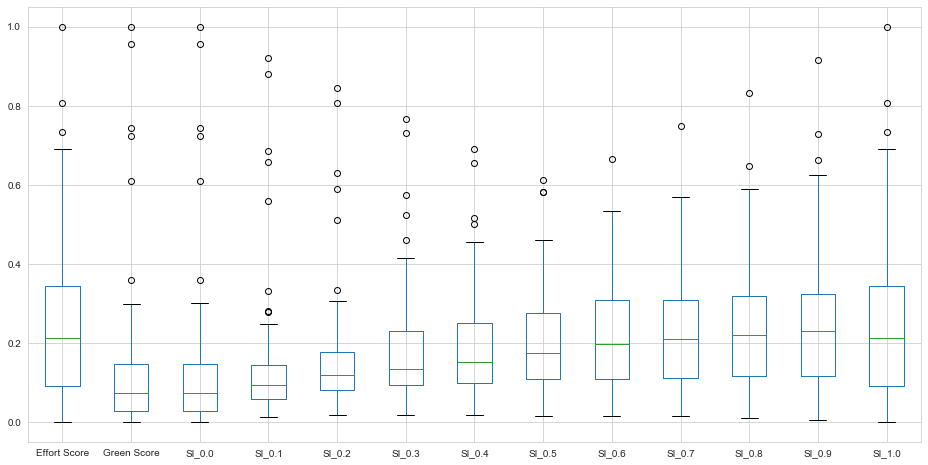

In [241]:
sus_df.plot(kind='box',figsize=(16,8));

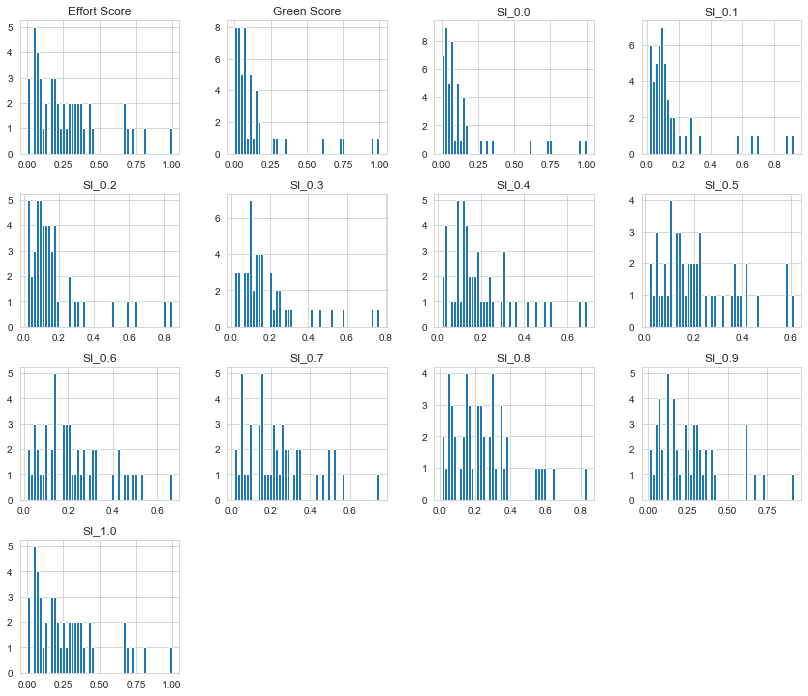

In [246]:
sus_df.hist(bins=50, figsize=(14,12));

Most states are closer to 0, but I feel this may simply be a matter of the scale of the data. Perhaps some form of standardization is necessary. Could look into this later.

In [293]:
si_range = np.arange(0.0, 1.1, 0.1)
si_range = np.round(si_range,1)

marks={}
for i in si_range:
    if i == 0.0:
        marks[str(i)] = 'Green Score'
    elif i == 1.0:
        marks[str(i)] = 'Effort Score'
    else:
        marks[str(i)] = ''

print(marks)

{'0.0': 'Green Score', '0.1': '', '0.2': '', '0.3': '', '0.4': '', '0.5': '', '0.6': '', '0.7': '', '0.8': '', '0.9': '', '1.0': 'Effort Score'}


In [298]:
si_range.mean()

0.5

In [157]:
best_es = sus_df[sus_df['Effort Score'] > 0.5].sort_values(by='Effort Score',ascending=False)
worst_es = sus_df[sus_df['Effort Score'] < 0.1].sort_values(by='Effort Score',ascending=False)

best_gs = sus_df[sus_df['Green Score'] > 0.5].sort_values(by='Green Score',ascending=False)
worst_gs = sus_df[sus_df['Green Score'] < 0.1].sort_values(by='Green Score',ascending=False)

In [152]:
plot_clusters(best_es.index)

In [156]:
plot_clusters(worst_es.index)

In [95]:
plot_clusters(best_gs.index)

In [109]:
plot_clusters(worst_gs.index)

In [316]:
sus_df.loc['Alabama']['Effort Score']

'0.077'

## Clustering to figure out the optimal way to group states into tiers of sustainability

Running elbow method to see optimal number of clusters and then will visualize results.

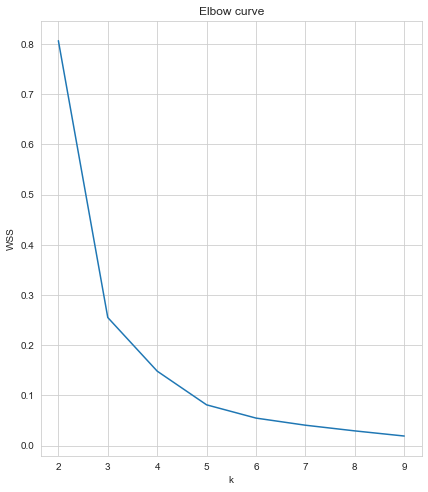

In [270]:
# Specifying the dataset and initializing variables
X = sus_df['SI_1.0']
distorsions = []

# Calculate SSE for different K
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state = 301)
    kmeans.fit(X.values.reshape(-1,1))
    distorsions.append(kmeans.inertia_)

# Plot values of SSE
plt.figure(figsize=(15,8))
plt.subplot(121, title='Elbow curve')
plt.xlabel('k')
plt.ylabel('WSS')
plt.plot(range(2, 10), distorsions)
plt.grid(True)

I select k=5, as it is an elbow in the graph. 3 Bins would be the obvious choice, but does not seem like a sufficient number of tiers.

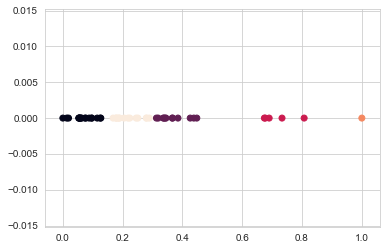

In [271]:
#fit the model to the ideal number of cluseters
clusters = KMeans(n_clusters=5, random_state = 10)

#create cluster labels 
cluster_labels = clusters.fit_predict(X.values.reshape(-1,1))

sus_df['labels_1.0'] = cluster_labels

# graph the scatterplot here
y_vals = np.zeros((50))
plt.scatter(sus_df['SI_1.0'],y_vals,c=cluster_labels);

This is too many clusters. I am comfortable with the clusters assigned between 0 - 0.5, but I want the 1.0 to be part of the highest tier. Thus, I will make k=4 and scale up.

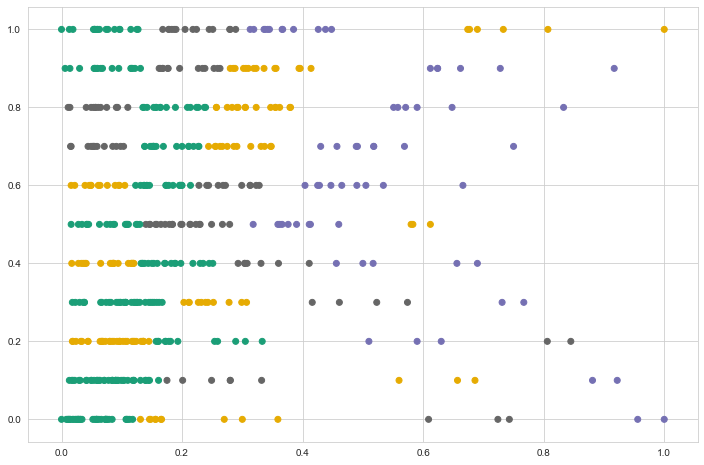

In [272]:
plt.figure(figsize=(12,8))

for number in si_range:
    
    number = round(number,1)
    
    # Assign X values
    X = sus_df[f'SI_{number}']
    
    #fit the model to 4 cluseters
    clusters = KMeans(n_clusters=4, random_state = 20)

    #create cluster labels 
    cluster_labels = clusters.fit_predict(X.values.reshape(-1,1))
    
    column_name = f'labels_{number}'
    
#     print(column_name)
    
    sus_df[column_name] = cluster_labels

    # graph the scatterplot here with the y value equaling the SI number
    y_vals = [number for i in range(0,50)]
    
    # Plot
    plt.scatter(sus_df[f'SI_{number}'],y_vals,c=sus_df[f'labels_{number}'],cmap='Dark2');


    

Some of the cutoffs in the lower SI numbers (y axis) are bad in the bottom two tiers, but honestly it's not a big deal. i could manually reassign those if I really wanted. K Means gives a great starting point for my clustering.

Honestly, now that I think about it, it may make more sense to not even have the clusters and just show a chloropleth map ultimately with a continuous color gradient indicating SI that you can adjust with a slider.

## Visualizing on a map

In [393]:
for col in sus_df.columns:
    sus_df[col] = sus_df[col].astype(str)

sus_df['text'] = sus_df.index + '<br>' + \
    'Sustainability Index: ' + sus_df['SI_0.0'] + '<br>' + \
    'Effort Score: ' + sus_df['Effort Score'] + '<br>' + \
    'Green Score: ' + sus_df['Green Score']

fig = go.Figure(data=go.Choropleth(
    locations=sus_df['code'],
    z=sus_df['SI_0.0'].astype(float),
    locationmode='USA-states',
    colorscale='Greens',
    autocolorscale=False,
    hovertext=sus_df['text'], # hover text
    marker_line_color='white', # line markers between states
    colorbar_thickness=10,
    colorbar_title="Green Score",
    colorbar_len=0.55
))

fig.update_layout(
    title_text='Green Scores',
    
    geo = dict(
        scope='usa',
        projection=go.layout.geo.Projection(type = 'albers usa'),
        showlakes=True, # lakes
        lakecolor='rgb(255, 255, 255)'),
    margin={'t':30,'b':20,'l':0,'r':0}
)

fig.show()

fig.write_image(f'figures/us_green_scores.png',scale=2)

## Get NY Data, group the data by sector, including total (renewable vs. nonrenewable)

In [97]:
renewable_sources = [
    'Biomass',
    'Fuel Ethanol excluding Denaturant',
    'Geothermal',
    'Hydroelectricity',
    'Solar Energy',
    'Wind Energy',
    'Renewable Sources'
    ]

nonrenewable_sources = [
    'All Petroleum Products',
    'Coal',
    'Natural Gas including Supplemental Gaseous Fuels',
    'Nuclear Power',
    'Nonrenewable Sources'
]

### Make combined Dataframes for each NY sector

In [320]:
# Create a dictionary containing all of NY's dataframes
dataframes = state_dfs['New York']

# Create a dataframe with just the temperature data
temp_df = helper_functions.get_weather_df(states_data['New York'])

# Concatenate all these bad boys
for sector in dataframes:
    dataframes[sector] = pd.concat([dataframes[sector], temp_df],axis=1)

TypeError: list indices must be integers or slices, not str

In [13]:
dataframes['Total All Sectors']

,Population,Natural Gas including Supplemental Gaseous Fuels,Renewable Energy,Biomass,Solar Energy,Wind Energy,Geothermal,Hydroelectricity,All Petroleum Products,Coal,...,days_below_30,days_below_25,days_below_20,days_below_15,days_below_10,days_below_5,Max Temp,Min Temp,Mean Temp,Std Temp
Date,,,,,,,,,,,,,,,,,,,,,
1960-01-01,16838,434127,189314,59263,0,0,0,130051,1700047,691728,...,0,0,0,0,0,0,102,45,78,15
1961-01-01,17061,450630,250832,57453,0,0,0,193379,1817656,634013,...,0,0,0,0,0,0,98,44,76,14
1962-01-01,17301,491055,277979,57324,0,0,0,220654,1883701,620891,...,0,0,0,0,0,0,101,33,78,15
1963-01-01,17461,520712,260059,57158,0,0,0,202901,1902730,643946,...,0,0,0,0,0,0,97,42,77,14
1964-01-01,17589,527890,247409,56954,0,0,0,190456,1888516,739638,...,0,0,0,0,0,0,101,39,76,15
1965-01-01,17734,558658,262743,58111,0,0,0,204632,2109451,755238,...,0,0,0,0,0,0,106,50,77,13
1966-01-01,17843,645684,288582,58726,0,0,0,229856,2220867,731385,...,0,0,0,0,0,0,101,44,77,14
1967-01-01,17935,602670,301664,57118,0,0,0,244545,2354677,726567,...,0,0,0,0,0,0,95,49,76,12
1968-01-01,18051,653282,320307,60128,0,0,0,260179,2416843,700146,...,0,0,0,0,0,0,99,47,76,14


# Visualize NY Renewable vs. Nonrenewable Energy Consumption Across Different Sectors

In [340]:
line_colors={
        'Nonrenewable Sources' : 'rgb(255,128,0)',
        'Renewable Sources' : 'rgb(0,168,84)'
}

In [359]:
x = [115,52.8,50.7]
y = ['Coal','Natural Gas','Oil']


fig = go.Figure()
fig.add_trace(go.Bar(
        x=x,
        y=y,
        orientation='h',
        marker_color='rgb(255,128,0)'))

fig.update_layout(
        title = 'Years of global fossil fuel reserves left',
        template = "plotly_white",
#         xaxis_title = 'Year',
#         yaxis_title = 'Energy Consumption (10<sup>15</sup> Btu)',
        yaxis_showgrid=False,
        xaxis_showgrid=True,
        yaxis_ticks='outside',
        yaxis_tickcolor='white',
        yaxis_ticklen=10,
        yaxis_zeroline=True,
        paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='rgba(0,0,0,0)',
#         legend_traceorder='normal',
#         xaxis_range=['2000-01-01', '2017-01-01'],
        width = 1000, #1000
        height = 500,  #600      
        )
fig.write_image(f'figures/years_fuel_left.png',scale=2)

In [504]:
for sector in ['Total All Sectors']:#sectors:
    
    plot_df = country_dfs['Total All Sectors']
    plot_df = plot_df.applymap(lambda x: round(x/1_000_000,2))
    
    fig = go.Figure()
    
    fig.add_trace(go.Scatter(
        x=plot_df.index.year,               
        y=plot_df['Renewable Sources'] + plot_df['Nonrenewable Sources'],                
        mode=None,  
        name='Total',        
        line_color='rgb(255,0,0)'
        )
    )
    
    fig.add_trace(go.Scatter(
        x=plot_df.index.year,        
        y=plot_df['Nonrenewable Sources'],           
        mode=None, 
        fill=None,
        name='Nonrenewable',
        line_color=line_colors['Nonrenewable Sources']   
        )
    )
    
    fig.add_trace(go.Scatter(
        x=plot_df.index.year,               
        y=plot_df['Renewable Sources'],                
        mode=None,  
        name='Renewable',        
        line_color=line_colors['Renewable Sources']
        )
    )
    
    
    
    
    fig.update_layout(
        title = 'U.S. Energy Consumption',
        template = "plotly_white",
        xaxis_title = 'Year',
        yaxis_title = 'Energy Consumption (10<sup>15</sup> Btu)',
        yaxis_showgrid=True,
        xaxis_showgrid=False,
        yaxis_ticks='outside',
        yaxis_tickcolor='white',
        yaxis_ticklen=10,
        yaxis_zeroline=True,
        paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='rgba(0,0,0,0)',
        legend_traceorder='normal',
#         yaxis_range=[0, 7],
#         xaxis_range=[2000, 2017],
        width = 1000, #1000
        height = 500,  #500      
        )
    
    fig.show()
#     filename=sector.lower().replace(' ','_')
    fig.write_image(f'figures/or_2000.png',scale=2)

In [27]:
dataframes['Total All Sectors']['Difference'] = dataframes['Total All Sectors']['Nonrenewable Sources'] - dataframes['Total All Sectors']['Renewable Sources']

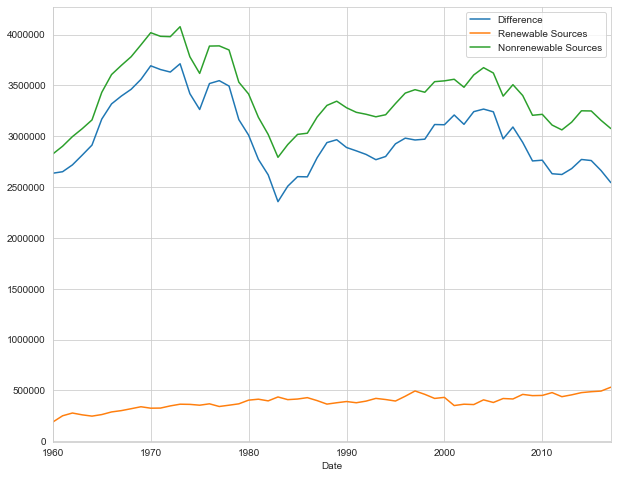

In [29]:
dataframes['Total All Sectors'][['Difference', 'Renewable Sources','Nonrenewable Sources']].plot(figsize=(10,8));

In [ ]:
import plotly
plotly.offline.plot(fig1, filename='nonrenewables.html')

In [10]:
e_columns = dataframes['Total All Sectors'].columns[1:14]

## Breaking down "All Sectors" by Energy Source

In [11]:
# fig = subplots.make_subplots(rows=3,cols=2)
fig1 = go.Figure()

for column in nonrenewable_sources:

    plot_df = dataframes['Total All Sectors']

    fig1.add_trace(go.Scatter(
        x=plot_df.index,        
        y=plot_df[column],           
        mode='lines',           
        name=re.findall('(\w* ?\w*)',column)[0],
#                 line_color='#6785be'
        )
    )


fig1.update_layout(
    title = 'NY Nonrenewable Energy Consumption - Total All Sectors',
    template = "plotly_white",
    xaxis_title = 'Year',
    yaxis_title = 'Energy Consumption (Billion Btu)',
    yaxis_showgrid=False,
    xaxis_showgrid=False,
    yaxis_ticks='outside',
    yaxis_tickcolor='white',
    yaxis_ticklen=10,
    yaxis_zeroline=False,
#     legend=go.layout.Legend(x=0.83,y=1.1),
    width = 1000, #1000
    height = 600  #600      
    )
fig2 = go.Figure()

for column in renewable_sources:

    plot_df = dataframes['Total All Sectors']

    fig2.add_trace(go.Scatter(
        x=plot_df.index,        
        y=plot_df[column],           
        mode='lines',           
        name=re.findall('(\w* ?\w*)',column)[0],
#                 line_color='#6785be'
        )
    )


fig2.update_layout(
    title = 'NY Renewable Energy Consumption - Total All Sectors',
    template = "plotly_white",
    xaxis_title = 'Year',
    yaxis_title = 'Energy Consumption (Billion Btu)',
    yaxis_showgrid=False,
    xaxis_showgrid=False,
    yaxis_ticks='outside',
    yaxis_tickcolor='white',
    yaxis_ticklen=10,
    yaxis_zeroline=False,
    width = 1000, #1000
    height = 600  #600      
    )

fig1.show()
fig2.show()
# filename=sector.lower().replace(' ','_')
fig1.write_image(f'figures/ny_nr_breakdown.png',scale=2)
fig2.write_image(f'figures/ny_r_breakdown.png',scale=2)
    

##  Breaking down Renewable and Nonrenewable by Sector

In [12]:
fig1 = go.Figure()

for sector in sectors:

    plot_df = dataframes[sector]

    fig1.add_trace(go.Scatter(
        x=plot_df.index,        
        y=plot_df['Nonrenewable Sources'],           
        mode='lines',           
        name=sector,
#                 line_color='#6785be'
        )
    )


fig1.update_layout(
    title = 'NY Nonrenewable Energy Consumption Across Sectors',
    template = "plotly_white",
    xaxis_title = 'Year',
    yaxis_title = 'Energy Consumption (Billion Btu)',
    yaxis_showgrid=False,
    xaxis_showgrid=False,
    yaxis_ticks='outside',
    yaxis_tickcolor='white',
    yaxis_ticklen=10,
    yaxis_zeroline=False,
#     legend=go.layout.Legend(x=0.83,y=1.1),
    width = 1000, #1000
    height = 600  #600      
    )
fig2 = go.Figure()

for sector in sectors:

    plot_df = dataframes[sector]

    fig2.add_trace(go.Scatter(
        x=plot_df.index,        
        y=plot_df['Renewable Sources'],           
        mode='lines',           
        name=sector,
#                 line_color='#6785be'
        )
    )


fig2.update_layout(
    title = 'NY Renewable Energy Consumption Across Sectors',
    template = "plotly_white",
    xaxis_title = 'Year',
    yaxis_title = 'Energy Consumption (Billion Btu)',
    yaxis_showgrid=False,
    xaxis_showgrid=False,
    yaxis_ticks='outside',
    yaxis_tickcolor='white',
    yaxis_ticklen=10,
    yaxis_zeroline=False,
    width = 1000, #1000
    height = 600  #600      
    )

fig1.show()
fig2.show()
# filename=sector.lower().replace(' ','_')
# fig1.write_image(f'figures/ny_nr_breakdown.png',scale=2)
# fig2.write_image(f'figures/ny_r_breakdown.png',scale=2)a

In [956]:
import plotly
plotly.offline.plot(fig1, filename='nonrenewables.html')

'nonrenewables.html'

# Visualize NY Nonrenewable Energy Consumption Across Decades - All Sectors

In [563]:
total_df = dataframes['Total All Sectors']

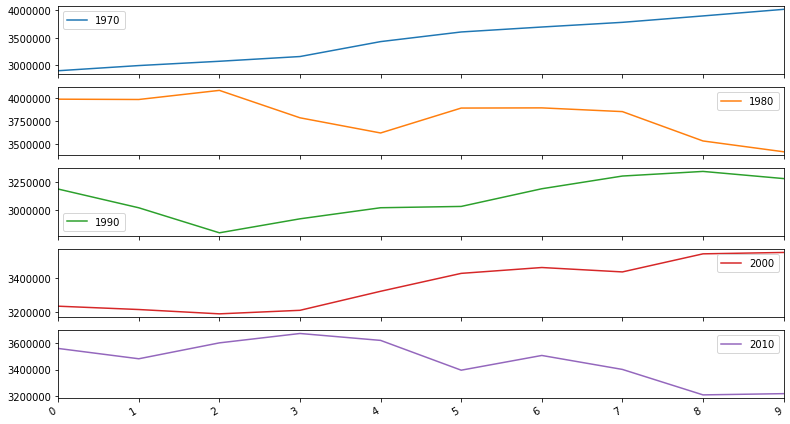

In [469]:
# Use pandas grouper to group values using annual frequency
nr_decade_groups = total_df['Nonrenewable Sources'].groupby(pd.Grouper(freq ='10Y'))

# Create a new DataFrame and store yearly values in columns 
nr_total_decades = pd.DataFrame()

for yr, group in nr_decade_groups:
    if yr.year > 1960 and yr.year < 2011:
        nr_total_decades[yr.year] = group.values
        

# Visualize NY Renewable Energy Consumption Across Decades - All Sectors

In [471]:
decades_melt = nr_total_decades.reset_index().melt(id_vars = 'index',
                                  value_vars = nr_total_decades.columns,
                                  var_name = 'Decade',
                                  value_name = 'Energy Consumed (Billion Btu)')

decades_melt.columns = ['Year Within Decade', 'Decade', 'Energy Consumed (Billion Btu)'] 

fig = px.line(decades_melt,
              x = decades_melt['Year Within Decade'],
              y = decades_mel['Energy Consumed (Billion Btu)'],
              color = 'Decade',
              title = 'New York Nonrenewable Energy Consumption - Total All Sectors')
fig

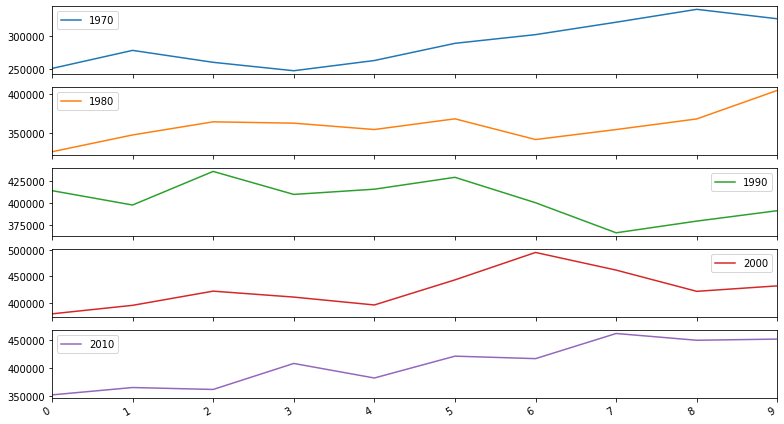

In [500]:
# Use pandas grouper to group values using annual frequency
r_decade_groups = total_df['Renewable Sources'].groupby(pd.Grouper(freq ='10Y'))

# Create a new DataFrame and store yearly values in columns 
r_total_decades = pd.DataFrame()

for yr, group in r_decade_groups:
    if yr.year > 1960 and yr.year < 2011:
        r_total_decades[yr.year] = group.values
        

# Plot the yearly groups as subplots
r_total_decades.plot(figsize = (13,8), subplots=True);

In [501]:
r_decades_melt = r_total_decades.reset_index().melt(id_vars = 'index',
                                  value_vars = r_total_decades.columns,
                                  var_name = 'Decade',
                                  value_name = 'Energy Consumed (Billion Btu)')

r_decades_melt.columns = ['Year Within Decade', 'Decade', 'Energy Consumed (Billion Btu)'] 

fig = px.line(r_decades_melt,
              x = 'Year Within Decade',
              y = 'Energy Consumed (Billion Btu)',
              color = 'Decade',
              title = 'New York Renewable Energy Consumption - Total All Sectors')
fig

# Visualize NY Temperature Data

In [1287]:
fig = go.Figure()

for column in temp_df.columns[3:-14]:

    fig.add_trace(go.Scatter(
        x=temp_df.index,        
        y=temp_df[column],           
        mode='lines',           
        name=column.title().replace('_',' ')+'F',
#         line_color='#6785be'
        )
    )
    
fig.update_layout(
    title = 'NY Temperature Trends',
    template = "plotly_white",
    xaxis_title = 'Year',
    yaxis_title = 'No. of Days per Year',
    yaxis_showgrid=False,
    xaxis_showgrid=False,
    yaxis_ticks='outside',
    yaxis_tickcolor='white',
    yaxis_ticklen=10,
    yaxis_zeroline=False,
    width = 1000, 
    height = 600  #600      
    )
# fig.write_image('figures/ny_temp_trends.png',scale=2) 

In [1296]:
fig = go.Figure()

for column in temp_df.columns[-4:]:

    fig.add_trace(go.Scatter(
        x=temp_df.index,        
        y=temp_df[column],           
        mode='lines',           
        name=column.title().replace('_',' '),
#         line_color='#6785be'
        )
    )
    
fig.update_layout(
    title = 'NY Temperature Statistics',
    template = "plotly_white",
    xaxis_title = 'Year',
    yaxis_title = 'Temperature (F)',
    yaxis_showgrid=False,
    xaxis_showgrid=False,
    yaxis_ticks='outside',
    yaxis_tickcolor='white',
    yaxis_ticklen=10,
    yaxis_zeroline=False,
    width = 1000, 
    height = 600  #600      
    )

# fig.write_image('figures/ny_temp_stats.png',scale=2) 

# Histograms

Using to show that due to the nature of linear statistical modeling and time series, we can only select data with normally distributed variables. We thus should only focus predictions for each state on renewable vs. nonrenewable energy in **Total All Sectors**. 

In [962]:
for sector in sectors:
    plot_df = dataframes[sector]
    
    fig = go.Figure()
    
    fig.add_trace(go.Histogram(
        x=plot_df['Renewable Sources'],
        name='Renewable',
        histnorm='probability'),
        )
    
    fig.add_trace(go.Histogram(
        x=plot_df['Nonrenewable Sources'],
        name='Nonrenewable',
        histnorm='probability')
        )
    
    fig.update_layout(height=500, 
                      width=1000, 
                      template = "plotly_white",
                      title = sector,
                      xaxis_title='Energy Consumption (Billion Btu)',
                      barmode='overlay'
                      )
    fig.update_traces(opacity=0.75)
    
    fig.show()
    filename=sector.lower().replace(' ','_')
#     fig.write_image(f'figures/ny_{filename}_hist.png',scale=2)
    


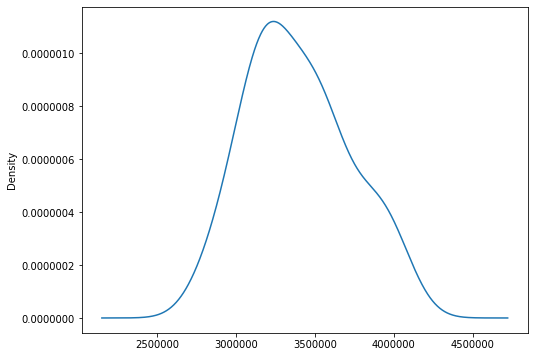

In [524]:
total_df['Nonrenewable Sources'].plot(kind='kde', figsize = (8,6));

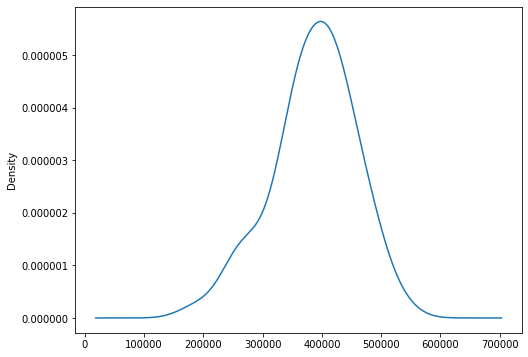

In [525]:
total_df['Renewable Sources'].plot(kind='kde', figsize = (8,6));

In [855]:
exo_columns = list(total_df.columns[17:26]) + list(total_df.columns[-4:])

In [856]:
exo_columns

['days_above_85',
 'days_above_80',
 'days_above_75',
 'days_above_70',
 'days_below_70',
 'days_below_65',
 'days_below_60',
 'days_below_55',
 'days_below_50',
 'Max Temp',
 'Min Temp',
 'Mean Temp',
 'Std Temp']

In [872]:
fig = subplots.make_subplots(rows=3,
                             cols=5,
                             subplot_titles=[column.replace('_',' ').title() for column in  exo_columns],
                            shared_yaxes=True)

fig.update_layout(height=800, 
                      width=1400, 
                      template = "plotly_white",
                      title = 'Temperature Frequency Distributions',
                      )

for index in range(len(exo_columns)):
    
    if index > 8:
        xaxis_label = 'Temperature (F)'
    else:
        xaxis_label = 'No. of Days per Year'
    
    row = (index // 5) + 1
    col = index % 5 + 1
    
#     print(index, row, col)
    
    fig.add_trace(go.Histogram(
        
        x=temp_df[exo_columns[index]],
        showlegend=False,
        marker_color='#3c19f0'),
        col=col,row=row,
        )

    # Update xaxis properties
    fig.update_xaxes(title_text=xaxis_label, 
                     showgrid=False, 
                     zeroline=False,ticks='outside',
                      tickcolor='white',
                      ticklen=10,
                     row=row, col=col)

    # Update yaxis properties
    
    fig.update_yaxes(showgrid=False,
                     zeroline=False,ticks='outside',
                      tickcolor='white',
                      ticklen=10, 
                     row=row, col=col)
    if col == 1:
        fig.update_yaxes(title_text='Frequency',row=row, col=col)
    
fig.show()
filename=sector.lower().replace(' ','_')
fig.write_image('figures/ny_temp_hists.png',scale=2)

In [901]:
fig = subplots.make_subplots(cols=2,
                           subplot_titles=['NY Population','NY Population Frequency Distribution'])

fig.add_trace(go.Scatter(
    x=total_df.index,
    y=total_df['Population'],
    showlegend=False),
         row=1,col=1
                        )
fig.add_trace(go.Histogram(
    x=total_df['Population'],
    nbinsx=18,
    showlegend=False),
                      row=1,col=2)

fig.update_layout(
    width = 1300, #1000
    height = 500  #600  
              )

# Update xaxis properties
fig.update_xaxes(title_text='Year', 
                 showgrid=False, 
                 zeroline=False,ticks='outside',
                  tickcolor='white',
                  ticklen=10,
                 row=1, col=1)
fig.update_xaxes(title_text='Population', 
                 showgrid=False, 
                 zeroline=False,ticks='outside',
                  tickcolor='white',
                  ticklen=10,
                row=1, col=2)
# Update yaxis properties

fig.update_yaxes(showgrid=False,
                 zeroline=False,ticks='outside',
                  tickcolor='white',
                  ticklen=10, 
                 row=1, col=1)


fig.update_yaxes(showgrid=False,
                 zeroline=False,ticks='outside',
                  tickcolor='white',
                  ticklen=10, 
                 row=1, col=2)
   
        
fig.show()
fig.write_image('figures/ny_pop_fig.png',scale=2)

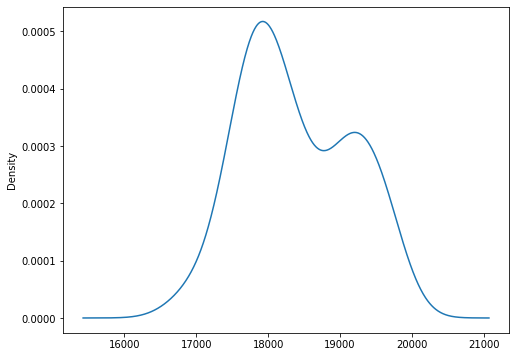

In [593]:
total_df['Population'].plot(kind='kde', figsize = (8,6));

In [824]:
2%4

2

In [859]:
temp_df.columns

Index(['days_above_100', 'days_above_95', 'days_above_90', 'days_above_85',
       'days_above_80', 'days_above_75', 'days_above_70', 'days_below_70',
       'days_below_65', 'days_below_60', 'days_below_55', 'days_below_50',
       'days_below_45', 'days_below_40', 'days_below_35', 'days_below_30',
       'days_below_25', 'days_below_20', 'days_below_15', 'days_below_10',
       'days_below_5', 'Max Temp', 'Min Temp', 'Mean Temp', 'Std Temp'],
      dtype='object')

For the most part, none of these variables are normally distributed. Population seems to be bivariate interestingly. So maybe that will not be such a great predictor in the final model.

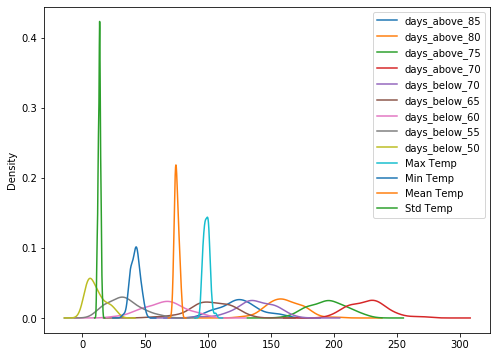

In [592]:
total_df[exo_columns[1:]].plot(kind='kde', figsize = (8,6));

# Summarize Findings So Far

1. New York nonrenewable energy consumption is/has much been much greater than its renewable counterpart throughout history
2. It appears that the trend over the last 20 years is that nonrenewable consumption is decreasing, while renewable consumption is increasing - many factors likely involving awareness of climate change, legislation, decreasing prices of renewable energy sources.
3. Histograms/KDE plots of energy consumption show that of all sectors, only the aggregated sector of "Total All Sectors" exhibits normally distributed energy consumption across renewable and nonrenewable energy. We'll therefore limit the scope of any forecasting to "Total All Sectors" for any state moving forward.
4. Histograms/KDE plots of exogenous variables show that pretty much all temperature designations exhibit normal, or mostly normal frequency distributions. Thus, all of these are fair game for the model.
5. Histogram/KDE plot of population reveals a bivariate distribution, which may be an issue going forward.

I dont think any logarithmic transformations will help here, but scaling will be necessary before training a model.

# Testing Stationarity

In [491]:
r_ts = dataframes['Total All Sectors']['Renewable Sources']
nr_ts = dataframes['Total All Sectors']['Nonrenewable Sources']

r_roll_mean = r_ts.rolling(window=6, center=False).mean()
r_roll_std = r_ts.rolling(window=6, center=False).std()

nr_roll_mean = nr_ts.rolling(window=6, center=False).mean()
nr_roll_std = nr_ts.rolling(window=6, center=False).std()

In [398]:
# Create traces
fig = subplots.make_subplots(rows = 2, 
                             cols = 1,
                             vertical_spacing = 0.15,
                             subplot_titles = ['NY Renewable Energy Consumption Rolling Mean & Standard Deviation', 
                                               'NY Nonrenewable Energy Consumption Rolling Mean & Standard Deviation'])

fig.add_trace(go.Scatter(x=dates[::-1], 
                         y=r_ts,
                         mode='lines',
                         name='Original',
#                          legendgroup = 'r',
                         line_color='#f8432d'
                         ), 
              row = 1,
              col = 1,
             )

fig.add_trace(go.Scatter(x=dates[::-1], 
                         y=r_roll_mean,
                         mode='lines',
                         name='Rolling Mean',
#                          legendgroup = 'r',
                         line_color='#6785be'
                        ),
              row = 1,
              col = 1)

fig.add_trace(go.Scatter(x=dates[::-1], 
                         y=r_roll_std,
                         mode='lines', 
                         name='Rolling Std',
#                          legendgroup = 'r',
                         line_color='rgb(150,150,150)'
                        ),
              row = 1, 
              col = 1)


fig.add_trace(go.Scatter(x=dates[::-1], 
                         y=nr_ts,
                         mode='lines',
                         name='Original',
                         showlegend=False,
                         line_color='#f8432d'),
              row = 2,
              col = 1)

fig.add_trace(go.Scatter(x=dates[::-1], 
                         y=nr_roll_mean,
                         mode='lines',
                         name='Rolling Mean',
                         showlegend=False,
                         line_color='#6785be'),
              row = 2,
              col = 1)

fig.add_trace(go.Scatter(x=dates[::-1], 
                         y=nr_roll_std,
                         mode='lines',
                         name='Rolling Std',
                         showlegend=False,
                         line_color='rgb(150,150,150)'),
              row = 2,
              col = 1)

fig.update_layout(height=800, 
                  width=1000, 
                  template = "plotly_white",
                  )


# Update xaxis properties
fig.update_xaxes(title_text='Year', 
                 showgrid=False, 
                 zeroline=False, 
#                  ticks='outside',
#                  tickcolor='white',
#                  ticklen=10, 
                 row=1, col=1)

fig.update_xaxes(title_text='Year', 
                 showgrid=False, 
                 zeroline=False, 
#                  ticks='outside',
#                  tickcolor='white',
#                  ticklen=10, 
                 row=2, col=1)


# Update yaxis properties
fig.update_yaxes(title_text='Energy Consumption (Billion Btu)', 
                 showgrid=False,
                 ticks='outside',
                 tickcolor='white',
                 ticklen=10,
                 zeroline=False, row=1, col=1)
fig.update_yaxes(title_text='Energy Consumption (Billion Btu)', 
                 showgrid=False,
                 ticks='outside',
                 tickcolor='white',
                 ticklen=10,
                 zeroline=False, 
                 row=2, col=1)


fig.show()

NameError: name 'dates' is not defined

In [870]:
import os

if not os.path.exists("figures"):
    os.mkdir("figures")
    
fig.write_image("figures/rolling_stats.png",scale=2)

#### The rolling means for both of the above graphs are not constant over time, indicating that our series are not stationary. Below is a Dickey-Fuller test to confirm with statistical confidence.

In [399]:
def dickey_fuller_comparison(series_1_data, series_2_data, series_1_name, series_2_name):
    """
    Returns a df with dickey fuller results for both the renewable and nonrenewable time series.
    
    Param series_1_data: [pd.Series] time series of renewable energy
    Param series_2_data: [pd.Series] time series of nonrenewable energy
    
    Param series_1_name: [str] name of series_1_data
    Param series_2_name: [str] name of series_2_data
    """

    dftest_1 = adfuller(series_1_data)
    dfoutput_1 = pd.Series(dftest_1[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key,value in dftest_1[4].items():
        dfoutput_1['Critical Value (%s)'%key] = value

    dftest_2 = adfuller(series_2_data)
    dfoutput_2 = pd.Series(dftest_2[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key,value in dftest_2[4].items():
        dfoutput_2['Critical Value (%s)'%key] = value

    df_results = pd.concat([dfoutput_1, dfoutput_2],axis=1)
    df_results.columns = [series_1_name, series_2_name]
    
    return df_results

In [400]:
dickey_fuller_comparison(r_ts, nr_ts, 'Renewable Sources', 'Nonrenewable Sources')

,Renewable Sources,Nonrenewable Sources
Test Statistic,1.585274,-3.845416
p-value,0.997813,0.002475
#Lags Used,11.000000,11.000000
Number of Observations Used,46.000000,46.000000
Critical Value (1%),-3.581258,-3.581258
Critical Value (5%),-2.926785,-2.926785
Critical Value (10%),-2.601541,-2.601541


Using 1% critical value, we find that both test statistics are greater than the critical value and thus fail to reject the null hypothesis. Therefore, both time series exhibit non-stationary behavior.

## Removing Trends

In [402]:
def plot_trend(series,title):
    

    # Create traces
    fig = go.Figure()

    # fig.add_trace(go.Scatter(x=dates[::-1], 
    #                          y=r_ts,
    #                          mode='lines',
    #                          name='Original',
    # #                          legendgroup = 'r',
    #                          line_color='#f8432d'
    #                          )
    #              )

    # fig.add_trace(go.Scatter(x=dates[::-1], 
    #                          y=r_roll_mean,
    #                          mode='lines',
    #                          name='Rolling Mean',
    # #                          legendgroup = 'r',
    #                          line_color='#6785be'
    #                         )
    #              )

    fig.add_trace(go.Scatter(x=dates[::-1], 
                             y=series,
                             mode='lines', 
                             name='Original Minus Rolling Mean',
    #                          legendgroup = 'r',
                             line_color='rgb(150,150,150)'
                            )
                 )



    fig.update_layout(height=600, 
                      width=800, 
                      template = "plotly_white",
                      title=title
                      )


    # Update xaxis properties
    fig.update_xaxes(title_text='Year', 
                     showgrid=False, 
                     zeroline=False, 
    #                  ticks='outside',
    #                  tickcolor='white',
    #                  ticklen=10, 
                     )



    # Update yaxis properties
    fig.update_yaxes(title_text='Energy Consumption (Billion Btu)', 
                     showgrid=False,
                     ticks='outside',
                     tickcolor='white',
                     ticklen=10,
                     zeroline=False)
    
    fig.show()


In [403]:
fig = go.Figure()
for i in range(2,11):
    roll_mean = r_ts.rolling(window=i, center=False).mean()

    fig.add_trace(go.Scatter(x=dates[::-1], 
                             y=(r_ts-roll_mean).dropna(),
                             mode='lines', 
                             name=f'Window = {i}',
                            )
                 )

fig.update_layout(height=600, 
                  width=800, 
                  template = "plotly_white",
                  title='Comparing Rolling Mean Windows'
                  )

# Update xaxis properties
fig.update_xaxes(title_text='Year', 
                 showgrid=False, 
                 zeroline=False,
                ) 

# Update yaxis properties
fig.update_yaxes(title_text='Energy Consumption (Billion Btu)', 
                 showgrid=False,
                 ticks='outside',
                 tickcolor='white',
                 ticklen=10,
                 zeroline=False)
    
fig.show()
    

NameError: name 'dates' is not defined

By comparing window = 2 to window = 10 we see that smaller windows tend to have more even amplitude in signal. In particular, I'm looking to minimize the difference in the huge up/down peak around 1987-1995 in window=10. We see that this feature appears around 1993-2002 in window=2 but is much less pronounced. Window=2 may ideal.

I'll now run dickey-fuller tests to confirm.

In [ ]:
print('Window ', 'Test Stat ', 'P Value   ','Critical Value (1%) ','Test Stat < Tcrit   \n')
for i in range(2,11):
    roll_mean = r_ts.rolling(window=i, center=False).mean()
    results = dickey_fuller_comparison(r_ts,(r_ts - roll_mean).dropna(),'Renewable Sources','Results')
    
    print(i, '  ',
          round(results['Results'][0],4),'  ',
          round(results['Results'][1],4), '  ',
          round(results['Results'][4],4), '  ',
          results['Results'][0] < results['Results'][4])

The lowest window with passing test statistic is window = 4.

In [1217]:
dickey_fuller_comparison(r_ts,r_ts.diff(1).dropna(),'Renewable Sources','First Difference')

,Renewable Sources,First Difference
Test Statistic,-0.378808,-2.355927
p-value,0.913577,0.154564
#Lags Used,11.000000,10.000000
Number of Observations Used,46.000000,46.000000
Critical Value (1%),-3.581258,-3.581258
Critical Value (5%),-2.926785,-2.926785
Critical Value (10%),-2.601541,-2.601541


Turns out taking the first difference is also somewhat effective, but does not pass the dickey-fuller test.

## Correlation

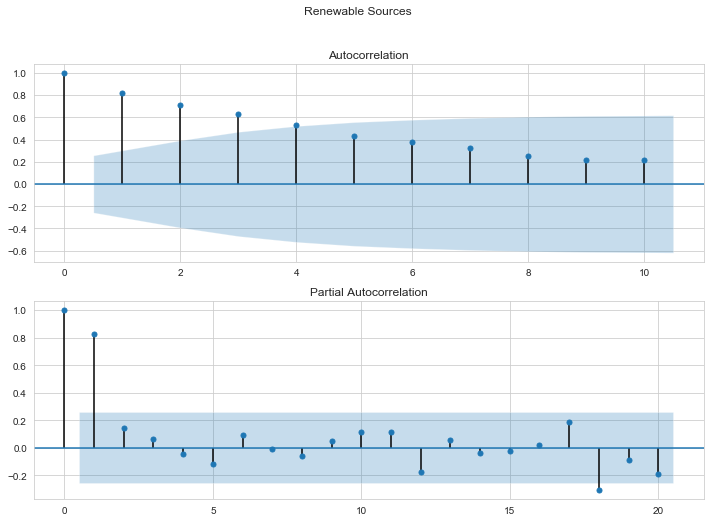

In [1146]:
fig = plt.figure(figsize=(12,8))
fig.suptitle('Renewable Sources')
ax1 = fig.add_subplot(211)
#plot the ACF
fig = sm.graphics.tsa.plot_acf(r_ts, lags=10, ax=ax1)
ax2 = fig.add_subplot(212)
#plot the PACF
fig = sm.graphics.tsa.plot_pacf(r_ts, lags=20, ax=ax2)

First several values of ACF show high correlation, meaning we shoulk take a first difference.

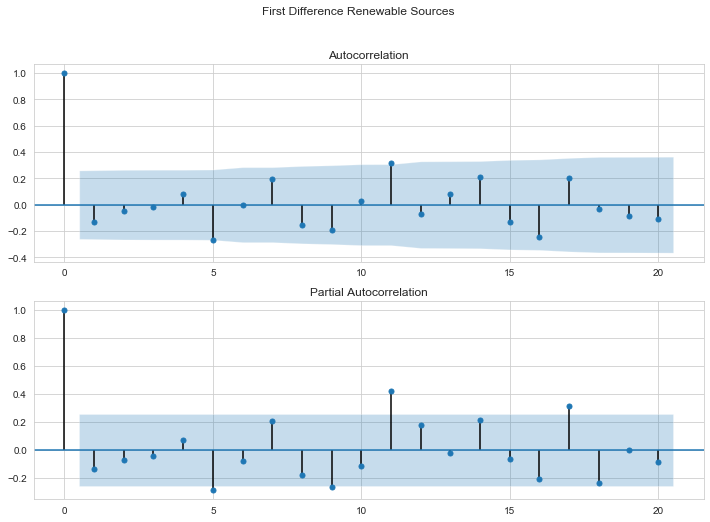

In [1148]:
r_ts_diff = r_ts.diff(1).dropna()

fig = plt.figure(figsize=(12,8))

fig.suptitle('First Difference Renewable Sources')

ax1 = fig.add_subplot(211)
#plot the ACF
fig = sm.graphics.tsa.plot_acf(r_ts_diff, lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
#plot the PACF
fig = sm.graphics.tsa.plot_pacf(r_ts_diff, lags=20, ax=ax2)

Lack of correlation here supports claim of no seasonality but also indicates no AR or MA terms are necessary. ARIMA probably will not well model this data. This is likley due to the fact that there are only 56 available data points. Most of the interesting seasonality probably occurs at the monthly level, which I do not have at my disposal.

# Univariate Modeling

To get a baseline idea of how well we can model the data using ARIMA or some combination of AR/MA, we will model the data using just the energy data

TypeError: float() argument must be a string or a number, not 'Period'

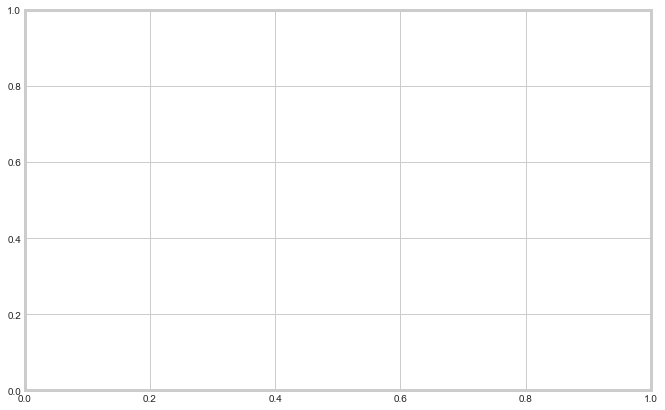

In [490]:
r_ts.plot(figsize=(10,7),title='NY Renewable Energy Consumption')

In [492]:
pd.DataFrame(r_train)

,Renewable Sources
Date,
2017-01-01,531861
2016-01-01,493757
2015-01-01,487662
2014-01-01,478681
2013-01-01,456717
2012-01-01,438718
2011-01-01,478792
2010-01-01,451127
2009-01-01,449012


In [493]:
r_train = r_ts[10:]
r_test = r_ts[:10]

In [414]:
from pmdarima import auto_arima

In [495]:
auto_arima(r_train,
           seasonal=False,
           stationary=False,
           m=1).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                   48
Model:               SARIMAX(3, 1, 3)   Log Likelihood                -532.830
Date:                Thu, 23 Jan 2020   AIC                           1081.661
Time:                        09:38:27   BIC                           1096.462
Sample:                             0   HQIC                          1087.230
                                 - 48                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -8850.0737   1.51e+04     -0.586      0.558   -3.84e+04    2.07e+04
ar.L1         -1.2861      0.078    -16.436      0.000      -1.439      -1.133
ar.L2         -1.3639      0.053    -25.713      0.000      -1.468      -1.260
ar.L3         -0.7925      0.067    -11.902      0.000      -0.923      -0.662
ma.L1          1.4354      1.445      0.994      0.320      -1.396       4.267
ma.L2          1.4363      1.412      1.017      0.309      -1.331       4.204
ma.L3          0.9984      0.186      5.378      0.000       0.635       1.362
sigma2      3.501e+08      0.000   2.57e+12      0.000     3.5e+08     3.5e+08
===================================================================================
Ljung-Box (Q):                       58.63   Jarque-Bera (JB):                 4.67
Prob(Q):                              0.03   Prob(JB):                         0.10
Heteroskedasticity (H):               0.57   Skew:                             0.39
Prob(H) (two-sided):                  0.27   Kurtosis:                         4.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.51e+31. Standard errors may be unstable.
"""

In [496]:
r_model = sm.tsa.statespace.SARIMAX(r_train,
                                order=(3,1,3),
                            )
results = r_model.fit()
print(results.summary())

                           Statespace Model Results                           
Dep. Variable:      Renewable Sources   No. Observations:                   48
Model:               SARIMAX(3, 1, 3)   Log Likelihood                -537.791
Date:                Thu, 23 Jan 2020   AIC                           1089.582
Time:                        09:38:33   BIC                           1102.533
Sample:                    01-01-2007   HQIC                          1094.455
                         - 01-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3241      0.060    -22.223      0.000      -1.441      -1.207
ar.L2         -1.4167      0.035    -39.912      0.000      -1.486      -1.347
ar.L3         -0.8059      0.048    -16.921      0.0

In [499]:
predictions

1959-01-01    198607.454587
1958-01-01    197781.204332
1957-01-01    180075.161367
1956-01-01    197201.628378
1955-01-01    200274.175102
1954-01-01    186211.204200
1953-01-01    186677.708136
1952-01-01    203507.228809
1951-01-01    191894.737445
1950-01-01    183052.601004
Freq: -1AS-JAN, Name: ARIMA(0,1,0) Predictions, dtype: float64

TypeError: float() argument must be a string or a number, not 'Period'

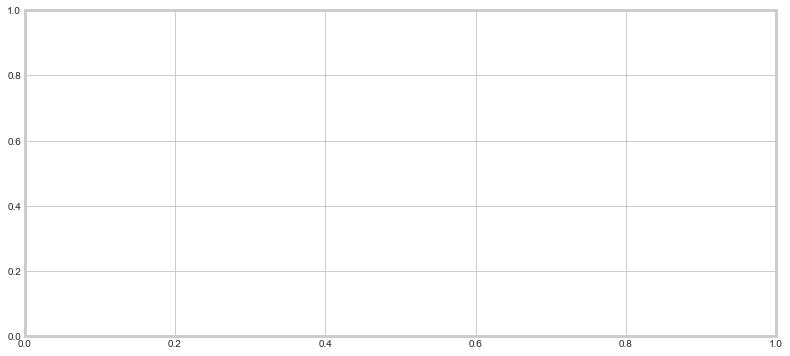

In [497]:
start=len(r_train)
end=len(r_train)+len(r_test)-1
predictions = results.predict(start=start, end=end, dynamic=False).rename('ARIMA(0,1,0) Predictions')

# Plot predictions against known values
title = 'NY Renewable Energy Consumption (Billion Btu)'
ylabel='Energy Consumption (Billion Btu)'
xlabel=''

ax = r_train.plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

Predicts a straight line because no AR or MA terms. Let's revisit the rolling window = 4 option.

## Revisiting Rolling Window = 2

In [1228]:
roll_mean_2 = r_ts.rolling(window=4, center=False).mean()
r_ts_roll = (r_ts - roll_mean_2).dropna()

dickey_fuller_comparison(r_ts,r_ts_roll,'Renewable Sources','Rolling Window Difference W=4')

,Renewable Sources,Rolling Window Difference W=4
Test Statistic,-0.378808,-3.935107
p-value,0.913577,0.001791
#Lags Used,11.000000,7.000000
Number of Observations Used,46.000000,47.000000
Critical Value (1%),-3.581258,-3.577848
Critical Value (5%),-2.926785,-2.925338
Critical Value (10%),-2.601541,-2.600774


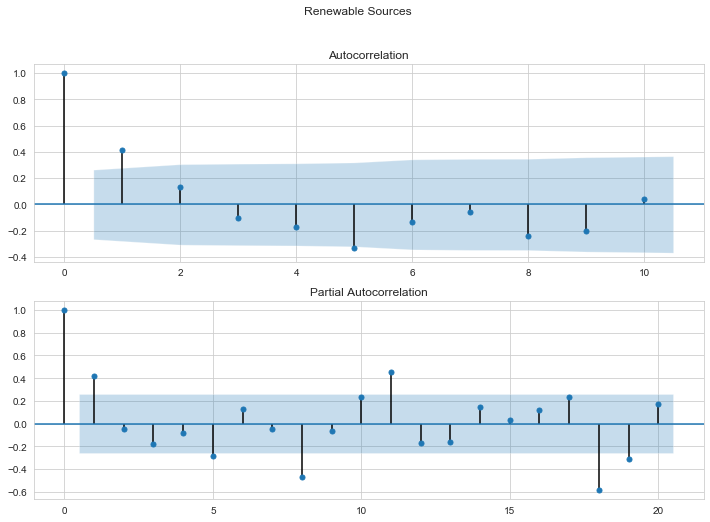

In [1229]:
fig = plt.figure(figsize=(12,8))
fig.suptitle('Renewable Sources')
ax1 = fig.add_subplot(211)
#plot the ACF
fig = sm.graphics.tsa.plot_acf(r_ts_roll, lags=10, ax=ax1)
ax2 = fig.add_subplot(212)
#plot the PACF
fig = sm.graphics.tsa.plot_pacf(r_ts_roll, lags=20, ax=ax2)

strong corr at lag = 1 suggests AR or MA term.

In [478]:
auto_arima(r_ts,
           seasonal=False,
           stationary=True,
           m=1).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                   58
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -676.263
Date:                Thu, 23 Jan 2020   AIC                           1358.526
Time:                        09:32:44   BIC                           1364.708
Sample:                             0   HQIC                          1360.934
                                 - 58                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    1.27e+04   1.81e+04      0.701      0.483   -2.28e+04    4.82e+04
ar.L1          0.9663      0.044     21.958      0.000       0.880       1.053
sigma2      7.009e+08      0.071   9.89e+09      0.000    7.01e+08    7.01e+08
===================================================================================
Ljung-Box (Q):                       64.69   Jarque-Bera (JB):                 2.46
Prob(Q):                              0.01   Prob(JB):                         0.29
Heteroskedasticity (H):               0.54   Skew:                             0.46
Prob(H) (two-sided):                  0.19   Kurtosis:                         3.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.94e+26. Standard errors may be unstable.
"""

In [1256]:
r_train = r_ts_roll[:-6]
r_test = r_ts_roll[-6:]

In [1257]:
r_model = sm.tsa.statespace.SARIMAX(r_train,
                                order=(2,0,2),
                            )
results = r_model.fit()
print(results.summary())

                           Statespace Model Results                           
Dep. Variable:      Renewable Sources   No. Observations:                   49
Model:               SARIMAX(2, 0, 2)   Log Likelihood                -553.494
Date:                Thu, 16 Jan 2020   AIC                           1116.988
Time:                        17:15:17   BIC                           1126.447
Sample:                    01-01-1963   HQIC                          1120.576
                         - 01-01-2011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6860      0.456     -1.503      0.133      -1.581       0.209
ar.L2         -0.0973      0.390     -0.249      0.803      -0.862       0.668
ma.L1          1.2577      0.303      4.147      0.0

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.



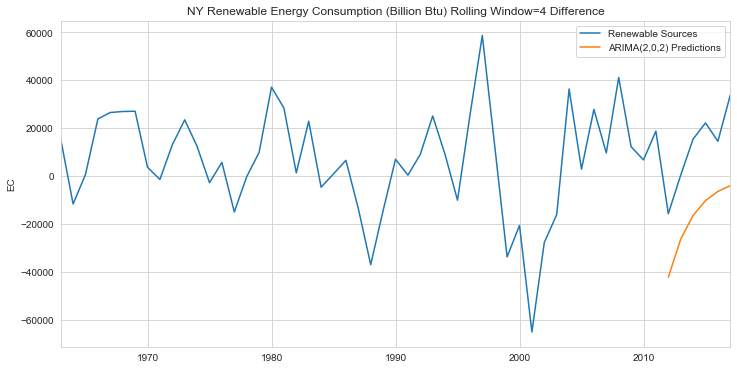

In [1285]:
start=len(r_train)
end=len(r_train)+len(r_test)-1
predictions = results.predict(start=start, end=end, dynamic=False).rename('ARIMA(2,0,2) Predictions')

# Plot predictions against known values
title = 'NY Renewable Energy Consumption (Billion Btu) Rolling Window=4 Difference'
ylabel='EC'
xlabel=''

ax = r_ts_roll.plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

Again, not great

# Try Whole Process Again for NR

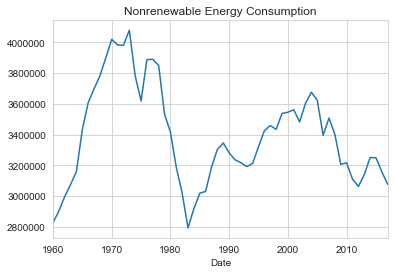

In [1262]:
nr_ts.plot(title='Nonrenewable Energy Consumption');

This probably will not go well either

In [1259]:
print('Window ', 'Test Stat ', 'P Value   ','Critical Value (1%) ','Test Stat < Tcrit   \n')
for i in range(2,11):
    roll_mean = nr_ts.rolling(window=i, center=False).mean()
    results = dickey_fuller_comparison(nr_ts,(nr_ts - roll_mean).dropna(),'Renewable Sources','Results')
    
    print(i, '  ',
          round(results['Results'][0],4),'  ',
          round(results['Results'][1],4), '  ',
          round(results['Results'][4],4), '  ',
          results['Results'][0] < results['Results'][4])

Window  Test Stat  P Value    Critical Value (1%)  Test Stat < Tcrit   

2    -5.261    0.0    -3.5529    True
3    -3.4017    0.0109    -3.5656    False
4    -3.2928    0.0152    -3.5602    False
5    -3.2817    0.0157    -3.5629    False
6    -3.1526    0.0229    -3.5656    False
7    -3.2543    0.017    -3.6056    False
8    -3.5208    0.0075    -3.6104    False
9    -2.7209    0.0705    -3.5886    False
10    -1.9899    0.291    -3.5925    False


window=2 is suitable. Let's see the full comparison below

In [1263]:
roll_mean_2 = nr_ts.rolling(window=4, center=False).mean()
nr_ts_roll = (nr_ts - roll_mean_2).dropna()

dickey_fuller_comparison(nr_ts,nr_ts_roll,'Nonrenewable Sources','Rolling Window Difference W=4')

,Nonrenewable Sources,Rolling Window Difference W=4
Test Statistic,-2.296522,-3.292795
p-value,0.173092,0.015204
#Lags Used,1.000000,1.000000
Number of Observations Used,56.000000,53.000000
Critical Value (1%),-3.552928,-3.560242
Critical Value (5%),-2.914731,-2.917850
Critical Value (10%),-2.595137,-2.596796


In [1278]:
auto_arima(nr_train,
           seasonal=False,
           stationary=True,
           m=1).summary()

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                   48
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -619.116
Date:                Thu, 16 Jan 2020   AIC                           1246.233
Time:                        17:23:19   BIC                           1253.717
Sample:                             0   HQIC                          1249.061
                                 - 48                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -5081.1261   1.76e+04     -0.289      0.772   -3.95e+04    2.94e+04
ar.L1          0.6245      0.129      4.851      0.000       0.372       0.877
ma.L1          0.2943      0.203      1.449      0.147      -0.104       0.693
sigma2      8.864e+09      0.070   1.27e+11      0.000    8.86e+09    8.86e+09
===================================================================================
Ljung-Box (Q):                       43.33   Jarque-Bera (JB):                 3.64
Prob(Q):                              0.33   Prob(JB):                         0.16
Heteroskedasticity (H):               0.62   Skew:                            -0.50
Prob(H) (two-sided):                  0.34   Kurtosis:                         3.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.23e+26. Standard errors may be unstable.
"""

In [1279]:
nr_train = nr_ts_roll[:-7]
nr_test = nr_ts_roll[-7:]

In [1280]:
nr_model = sm.tsa.statespace.SARIMAX(nr_train,
                                order=(1,0,1),
                            )
results = nr_model.fit()
print(results.summary())

                            Statespace Model Results                            
Dep. Variable:     Nonrenewable Sources   No. Observations:                   48
Model:                 SARIMAX(1, 0, 1)   Log Likelihood                -618.999
Date:                  Thu, 16 Jan 2020   AIC                           1243.998
Time:                          17:23:22   BIC                           1249.612
Sample:                      01-01-1963   HQIC                          1246.120
                           - 01-01-2010                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6237      0.124      5.035      0.000       0.381       0.867
ma.L1          0.2926      0.203      1.443      0.149      -0.105       0.690
sigma2      8.907e+09    2.4e-12   3

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.



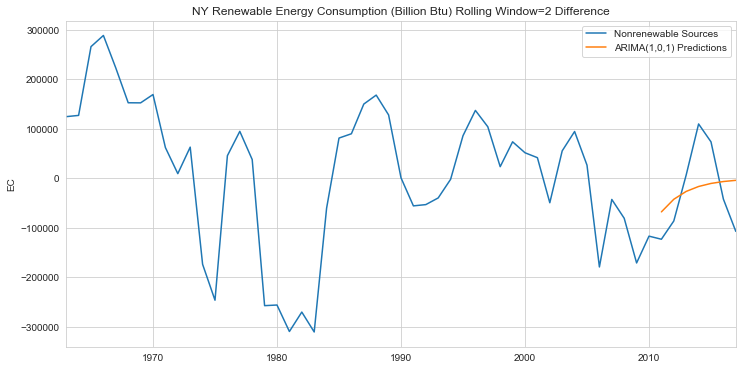

In [1284]:
start=len(nr_train)
end=len(nr_train)+len(nr_test)-1
predictions = results.predict(start=start, end=end, dynamic=False).rename('ARIMA(1,0,1) Predictions')

# Plot predictions against known values
title = 'NY Renewable Energy Consumption (Billion Btu) Rolling Window=2 Difference'
ylabel='EC'
xlabel=''

ax = nr_ts_roll.plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

# Multivariate Modeling

In [1290]:
df = dataframes['Total All Sectors']

In [1291]:
df.columns

Index(['Population', 'Natural Gas including Supplemental Gaseous Fuels',
       'Renewable Energy', 'Biomass', 'Solar Energy', 'Wind Energy',
       'Geothermal', 'Hydroelectricity', 'All Petroleum Products', 'Coal',
       'Nuclear Power', 'Fuel Ethanol excluding Denaturant',
       'Renewable Sources', 'Nonrenewable Sources', 'days_above_100',
       'days_above_95', 'days_above_90', 'days_above_85', 'days_above_80',
       'days_above_75', 'days_above_70', 'days_below_70', 'days_below_65',
       'days_below_60', 'days_below_55', 'days_below_50', 'days_below_45',
       'days_below_40', 'days_below_35', 'days_below_30', 'days_below_25',
       'days_below_20', 'days_below_15', 'days_below_10', 'days_below_5',
       'Max Temp', 'Min Temp', 'Mean Temp', 'Std Temp'],
      dtype='object')

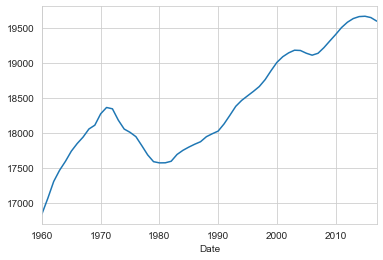

In [1294]:
df.Population.plot()


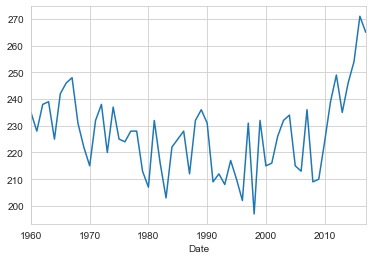

In [1295]:
df.days_above_70.plot()

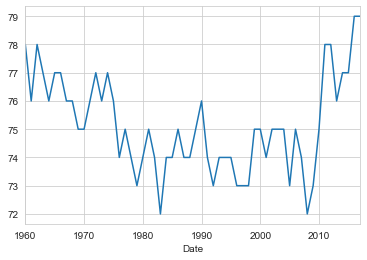

In [1297]:
df['Mean Temp'].plot()

In [1313]:
r_train = r_ts_roll[:-6]
r_test = r_ts_roll[-6:]
exog_train = df[['Population','Mean Temp']].iloc[3:-6,:]
exog_test = df[['Population','Mean Temp']].iloc[-6:,:]

In [1309]:
auto_arima(r_train,
           exogenous=exog_train,
           seasonal=False,
           stationary=False,
           m=1).summary()

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No 

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                   49
Model:               SARIMAX(2, 0, 1)   Log Likelihood                -551.950
Date:                Thu, 16 Jan 2020   AIC                           1117.899
Time:                        17:52:43   BIC                           1131.142
Sample:                    01-01-1963   HQIC                          1122.923
                         - 01-01-2011                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    342.6036   3.89e+04      0.009      0.993   -7.59e+04    7.66e+04
Population    -0.8356      6.743     -0.124      0.901     -14.052      12.381
Mean Temp    244.2574   2810.505      0.087      0.931   -5264.232    5752.747
ar.L1          1.3422      0.169      7.949      0.000       1.011       1.673
ar.L2         -0.4889      0.174     -2.804      0.005      -0.831      -0.147
ma.L1         -0.9877      0.295     -3.346      0.001      -1.566      -0.409
sigma2      3.853e+08      4.323   8.91e+07      0.000    3.85e+08    3.85e+08
===================================================================================
Ljung-Box (Q):                       38.36   Jarque-Bera (JB):                 3.25
Prob(Q):                              0.54   Prob(JB):                         0.20
Heteroskedasticity (H):               4.28   Skew:                            -0.48
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.67e+24. Standard errors may be unstable.
"""

In [1310]:
r_model = sm.tsa.statespace.SARIMAX(r_train,
                                    exog=exog_train,
                                    order=(2,0,1),
                            )
results = r_model.fit()
print(results.summary())

                           Statespace Model Results                           
Dep. Variable:      Renewable Sources   No. Observations:                   49
Model:               SARIMAX(2, 0, 1)   Log Likelihood                -551.973
Date:                Thu, 16 Jan 2020   AIC                           1115.946
Time:                        17:53:00   BIC                           1127.297
Sample:                    01-01-1963   HQIC                          1120.253
                         - 01-01-2011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Population    -0.7075      5.210     -0.136      0.892     -10.919       9.504
Mean Temp    244.2558   1277.496      0.191      0.848   -2259.590    2748.102
ar.L1          1.3427      0.168      7.999      0.0

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency AS-JAN will be used.



In [432]:
start=len(r_train)
end=len(r_train)+len(r_test)-1
predictions = results.predict(start=start, end=end, dynamic=False,exog=exog_test).rename('ARIMA(2,0,1) Predictions')

# Plot predictions against known values
title = 'NY Renewable Energy Consumption (Billion Btu) Rolling Window=4 Difference'
ylabel='EC'
xlabel=''

ax = r_ts_roll.plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

NameError: name 'exog_test' is not defined

# FB Prophet

In [30]:
!pip install pystan

     |████████████████████████████████| 39.1MB 33.7MB/s eta 0:00:01   |▏                               | 235kB 2.4MB/s eta 0:00:17     |████████████████████▉           | 25.4MB 12.2MB/s eta 0:00:02


In [31]:
!pip install fbprophet

     |████████████████████████████████| 51kB 2.8MB/s eta 0:00:01
     |████████████████████████████████| 92kB 7.8MB/s eta 0:00:011
     |████████████████████████████████| 737kB 16.6MB/s eta 0:00:01
  Created wheel for fbprophet: filename=fbprophet-0.5-cp37-none-any.whl size=680263 sha256=aa9ea9886a329abb372f69ef13381e313202bf756bd350d489e1ed56ea70cd11
  Stored in directory: /Users/Marco/Library/Caches/pip/wheels/16/61/45/2dce71b1055b65f28a8b75702664adee6c645e3e294178a202
  Created wheel for holidays: filename=holidays-0.9.12-cp37-none-any.whl size=47610 sha256=90ec0721517474d4c933f0e2c318b869e75ac523b77f71484b85c962e992833f
  Stored in directory: /Users/Marco/Library/Caches/pip/wheels/1f/fd/3a/f29866dc23dada18f25e9837477c82bbd7952aeef86fa46f11
  Created wheel for pymeeus: filename=PyMeeus-0.3.6-cp37-none-any.whl size=702822 sha256=153c91906a03ebd0a5e8b4c293957bc376aed480b5ee5d212672b4a4c15c3e63
  Stored in directory: /Users/Marco/Library/Caches/pip/wheels/d6/a7/fd/a3cc8df9eb57b13a7e893

In [405]:
#Import necessary libraries
import warnings
warnings.filterwarnings('ignore')


import pandas as pd 

# Matplotlib for plotting
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline
from matplotlib.pylab import rcParams
plt.style.use('fivethirtyeight')

from fbprophet import Prophet as proph



In [433]:
renewable_df = pd.DataFrame(r_ts)
renewable_df.reset_index(inplace=True)
renewable_df.columns = ['ds','y']

In [443]:
train_df = renewable_df.iloc[8:,:]
test_df = renewable_df.iloc[:8,:]

In [444]:
test_df

,ds,y
0,2017-01-01,531861
1,2016-01-01,493757
2,2015-01-01,487662
3,2014-01-01,478681
4,2013-01-01,456717
5,2012-01-01,438718
6,2011-01-01,478792
7,2010-01-01,451127


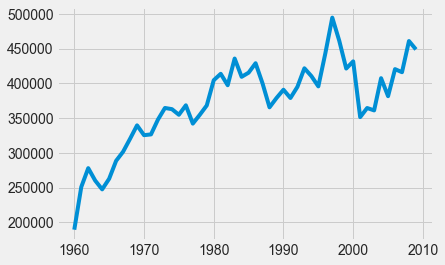

In [445]:
plt.plot(train_df.ds, train_df.y)

In [446]:
model=proph(interval_width=0.95)
model.fit(train_df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [500]:
future_dates = model.make_future_dataframe(periods=15,freq='Y')

In [501]:
forecast=model.predict(future_dates)
# forecast.head()

In [452]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
54,2013-12-31,439464.642366,383852.771872,495197.628049
55,2014-12-31,445311.310994,389737.308285,505439.901645
56,2015-12-31,452641.314182,396037.565964,514662.654609
57,2016-12-31,440691.462347,383125.179387,497788.602007
58,2017-12-31,445046.652623,390248.245784,499625.245091


51    439729.300737
52    447059.303924
53    435109.452090
54    439464.642366
55    445311.310994
56    452641.314182
57    440691.462347
58    445046.652623
Name: yhat, dtype: float64

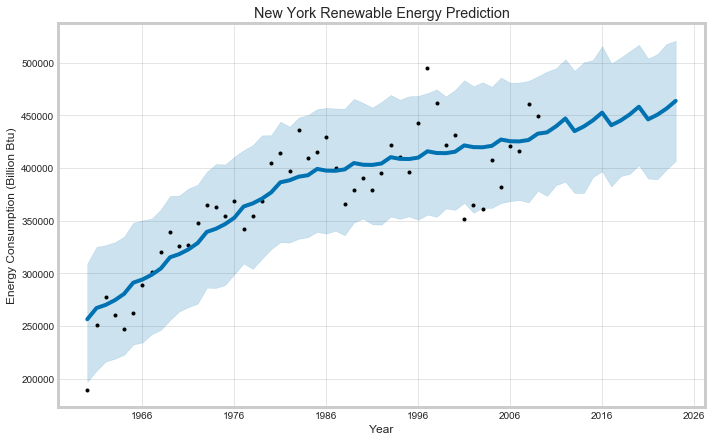

<Figure size 432x288 with 0 Axes>

In [502]:
model.plot(forecast, uncertainty=True)
plt.title('New York Renewable Energy Prediction')
plt.xlabel('Year')
plt.ylabel('Energy Consumption (Billion Btu)')
plt.show()
plt.savefig('figures/NY_rec_pred.png')

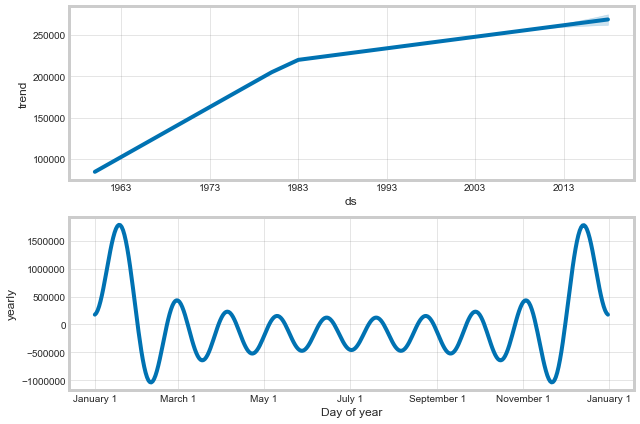

In [456]:
model.plot_components(forecast)
plt.show()

### Calculate RMSE

In [472]:
y_pred=forecast['yhat'].iloc[51:]
y_true = test_df['y'].values

In [477]:
np.sqrt(metrics.mean_squared_error(y_true,y_pred))

45800.092574868024